In [39]:
import os
import cv2
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

In [40]:
if torch.cuda.is_available():
    device = 'cuda' 
elif torch.backends.mps.is_available():
    device = 'mps'   
else:
    device = 'cpu'  

# Set dataset path
dataset_path = 'APS360_Project_Dataset/dataset4'

# Augmentation transform
augment_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])

# Preprocessing transform (normalization)
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Data loading and preprocessing function
def load_digits_and_preprocess(base_path):
    images = []
    labels = []
    
    for label in os.listdir(base_path):
        folder_path = os.path.join(base_path, label)
        
        if os.path.isdir(folder_path):
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                img = cv2.imread(img_path)
                
                if img is not None:
                    # Convert to PIL for transformation
                    img_pil = Image.fromarray(img)
                    # Apply augmentation
                    augmented_img = augment_transform(img_pil)
                    # Convert back to numpy and resize
                    aug_img_np = np.array(augmented_img.permute(1, 2, 0))
                    aug_img_np = cv2.resize(aug_img_np, (64, 64))  # Resize to 64x64
                    images.append(aug_img_np)
                    labels.append(int(label))  # Folder name is the label (0-9)
                else:
                    print(f"Warning: Failed to load image {img_path}")
    
    return images, labels


def split_data(images, labels, test_size=0.2, val_size=0.1, random_state=42):
    train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=test_size, random_state=random_state)
    train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=val_size, random_state=random_state)
    return train_images, train_labels, val_images, val_labels, test_images, test_labels


In [41]:
class DigitDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)  # Rescale if in [0, 1] range
        
        if self.transform:
            image = Image.fromarray(image)
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
        
        return image, label
    
def create_dataloaders(batch_size, train_images, train_labels, val_images, val_labels, test_images, test_labels):
    # Create Dataset instances
    train_dataset = DigitDataset(train_images, train_labels, transform=data_transform)
    val_dataset = DigitDataset(val_images, val_labels, transform=data_transform)
    test_dataset = DigitDataset(test_images, test_labels, transform=data_transform)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [42]:
# Load and preprocess data
images, labels = load_digits_and_preprocess(dataset_path)

# Split data into train, validation, and test sets
train_images, train_labels, val_images, val_labels, test_images, test_labels = split_data(images, labels)

# Create DataLoaders with specified batch size
batch_size = 8
train_loader, val_loader, test_loader = create_dataloaders(batch_size, train_images, train_labels, val_images, val_labels, test_images, test_labels)

# Print dataset sizes for verification
print(f"Train set: {len(train_loader.dataset)} images")
print(f"Validation set: {len(val_loader.dataset)} images")
print(f"Test set: {len(test_loader.dataset)} images")

Train set: 817 images
Validation set: 91 images
Test set: 228 images


In [65]:
import torch.nn as nn
import torch.nn.functional as F

class ImprovedDigitCNN(nn.Module):
    def __init__(self):
        super(ImprovedDigitCNN, self).__init__()
        
        # Convolutional Layers with Batch Norm
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)  # 10 classes for digits 0-9

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        
        x = x.view(-1, 128 * 8 * 8)  # Correct if the input image is 64x64
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [62]:
import os
import torch

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, save_dir='model_checkpoints'):
    # Create the directory for saving model checkpoints if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Lists to store loss and accuracy for plotting
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(epoch_loss)  # Store training loss
        train_accuracies.append(train_accuracy)  # Store training accuracy
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")
        
        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        val_accuracies.append(val_acc)  # Store validation accuracy
        print(f"Validation Accuracy: {val_acc:.2f}%")

        # Save the model after each epoch
        model_path = os.path.join(save_dir, f'model_epoch_{epoch+1}.pth')
        torch.save(model.state_dict(), model_path)
        print(f'Model saved to {model_path}')

    return train_losses, train_accuracies, val_accuracies


In [63]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, train_accuracies, val_accuracies, num_epochs):
    epochs = range(1, num_epochs + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100)
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1/30, Loss: 2.3776, Training Accuracy: 26.07%
Validation Accuracy: 53.85%
Model saved to model_checkpoints/model_epoch_1.pth
Epoch 2/30, Loss: 1.1309, Training Accuracy: 63.53%
Validation Accuracy: 76.92%
Model saved to model_checkpoints/model_epoch_2.pth
Epoch 3/30, Loss: 0.6145, Training Accuracy: 81.15%
Validation Accuracy: 69.23%
Model saved to model_checkpoints/model_epoch_3.pth
Epoch 4/30, Loss: 0.4291, Training Accuracy: 85.19%
Validation Accuracy: 80.22%
Model saved to model_checkpoints/model_epoch_4.pth
Epoch 5/30, Loss: 0.4040, Training Accuracy: 87.52%
Validation Accuracy: 83.52%
Model saved to model_checkpoints/model_epoch_5.pth
Epoch 6/30, Loss: 0.2041, Training Accuracy: 92.53%
Validation Accuracy: 79.12%
Model saved to model_checkpoints/model_epoch_6.pth
Epoch 7/30, Loss: 0.1367, Training Accuracy: 96.45%
Validation Accuracy: 78.02%
Model saved to model_checkpoints/model_epoch_7.pth
Epoch 8/30, Loss: 0.0908, Training Accuracy: 97.92%
Validation Accuracy: 83.52%
Mod

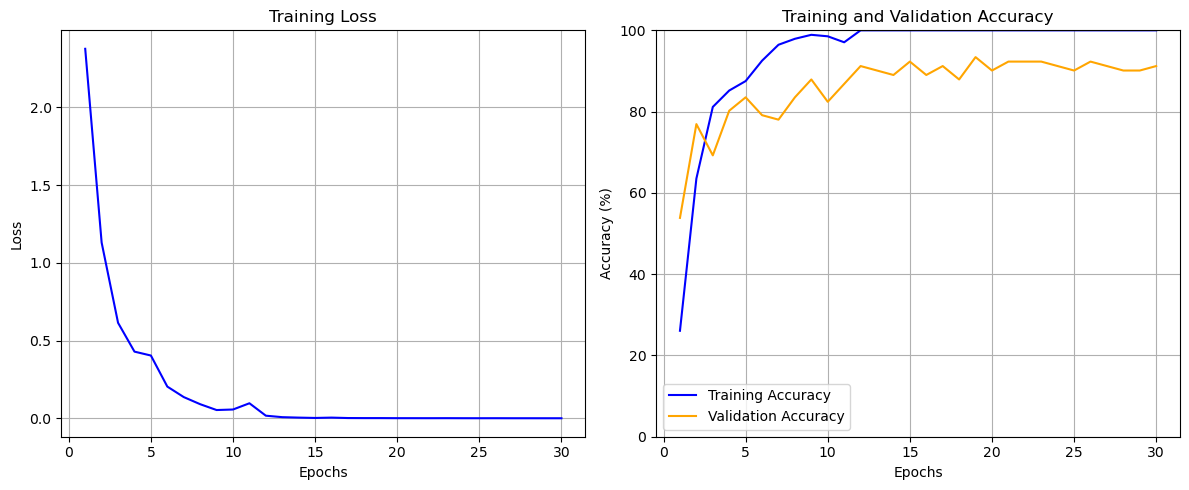

In [66]:
# Assuming you have already defined your model, criterion, optimizer, train_loader, and val_loader
model = ImprovedDigitCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30

# Train the model and capture losses and accuracies
train_losses, train_accuracies, val_accuracies = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)

# Plot the training curves
plot_training_curves(train_losses, train_accuracies, val_accuracies, num_epochs)


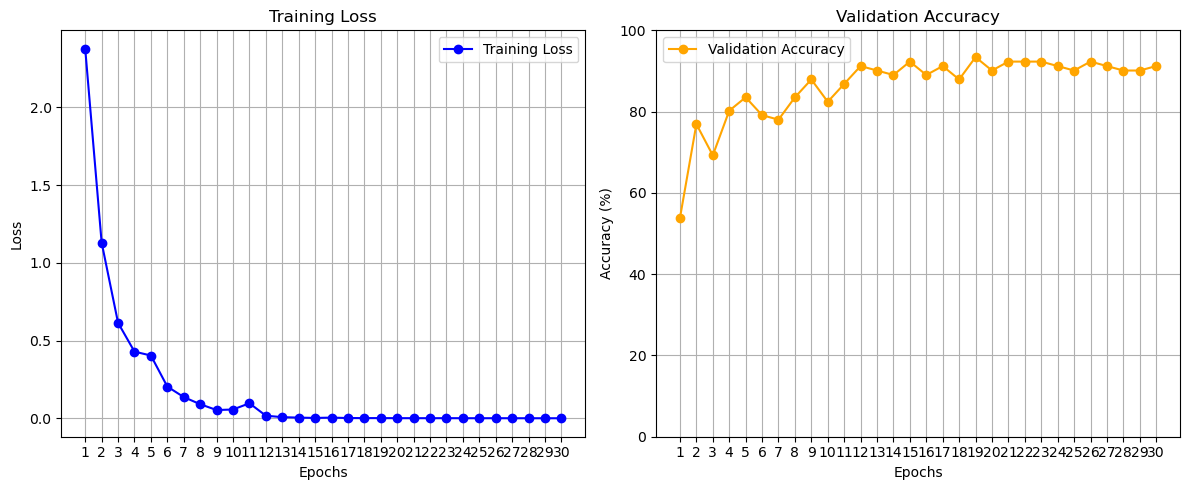

In [70]:
def plot_curves(train_losses, val_accuracies, num_epochs, save_dir='model_checkpoints'):
    plt.figure(figsize=(12, 5))

    # Plot Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue', marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(1, num_epochs + 1))
    plt.grid()
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange', marker='o')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.xticks(range(1, num_epochs + 1))
    plt.ylim(0, 100)
    plt.grid()
    plt.legend()

    # Save the figure
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_validation_curves.png'))
    plt.show()
    
plot_curves(train_losses, val_accuracies, 30)

In [55]:
model = ImprovedDigitCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_losses, val_accuracies = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=30)

# Test the model
test_model(model, test_loader)


Epoch 1/30, Loss: 2.4489
Validation Accuracy: 30.77%
Model saved to model_checkpoints/model_epoch_1.pth
Epoch 2/30, Loss: 1.3118
Validation Accuracy: 61.54%
Model saved to model_checkpoints/model_epoch_2.pth
Epoch 3/30, Loss: 0.7975
Validation Accuracy: 73.63%
Model saved to model_checkpoints/model_epoch_3.pth
Epoch 4/30, Loss: 0.5075
Validation Accuracy: 78.02%
Model saved to model_checkpoints/model_epoch_4.pth
Epoch 5/30, Loss: 0.3895
Validation Accuracy: 83.52%
Model saved to model_checkpoints/model_epoch_5.pth
Epoch 6/30, Loss: 0.2709
Validation Accuracy: 85.71%
Model saved to model_checkpoints/model_epoch_6.pth
Epoch 7/30, Loss: 0.1655
Validation Accuracy: 86.81%
Model saved to model_checkpoints/model_epoch_7.pth
Epoch 8/30, Loss: 0.1501
Validation Accuracy: 81.32%
Model saved to model_checkpoints/model_epoch_8.pth
Epoch 9/30, Loss: 0.0917
Validation Accuracy: 81.32%
Model saved to model_checkpoints/model_epoch_9.pth
Epoch 10/30, Loss: 0.0731
Validation Accuracy: 84.62%
Model save

In [56]:
cnn_model = ImprovedDigitCNN()
cnn_model.load_state_dict(torch.load('model_checkpoints/model_epoch_30.pth', map_location=device))
cnn_model.to(device)

test_model(cnn_model, test_loader)


Test Accuracy: 89.04%


In [50]:
def plot_training_curves(train_losses, val_accuracies, num_epochs):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue', marker='o')
    plt.title('Training Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.grid()
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green', marker='o')
    plt.title('Validation Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.xticks(epochs)
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
plot_training_curves(train_losses, val_accuracies, num_epochs=30)